In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [5]:
# No stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmesiz"

print("Images are loading...")
NS_images = data_generator(folder_path)

print(f"Total images: {NS_images.shape[0]}")
print(f"Shapes: {NS_images[0].shape}")

Images are loading...
Total images: 4427
Shapes: torch.Size([3, 256, 256])


In [6]:
# Stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmeli"

print("Images are loading...")
S_images = data_generator(folder_path, augmentation=True, augmentation_factor=1)

print(f"Total stroke images: {S_images.shape[0]}")
print(f"Stroke images shape: {S_images[0].shape}")

Images are loading...
Total stroke images: 4446
Stroke images shape: torch.Size([3, 256, 256])


In [7]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total no stroke test images: 130
No stroke test images shape: torch.Size([3, 256, 256])
Total stroke test images: 167
Stroke test images shape: torch.Size([3, 256, 256])


In [12]:
# External test images

folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
folder_path_external_S = "/content/drive/My Drive/veriler/test/baska_test/b_stroke"

print("Images are loading...")
external_NS_images = data_generator(folder_path_external_NS)
external_NS_images = external_NS_images[:192]
external_S_images = data_generator(folder_path_external_S)

print(f"Total external test no stroke images: {external_NS_images.shape[0]}")
print(f"External test no stroke images shape: {external_NS_images[0].shape}")

print(f"Total external test stroke images: {external_S_images.shape[0]}")
print(f"External test stroke images shape: {external_S_images[0].shape}")

Images are loading...
Total external test no stroke images: 192
External test no stroke images shape: torch.Size([3, 256, 256])
Total external test stroke images: 192
External test stroke images shape: torch.Size([3, 256, 256])


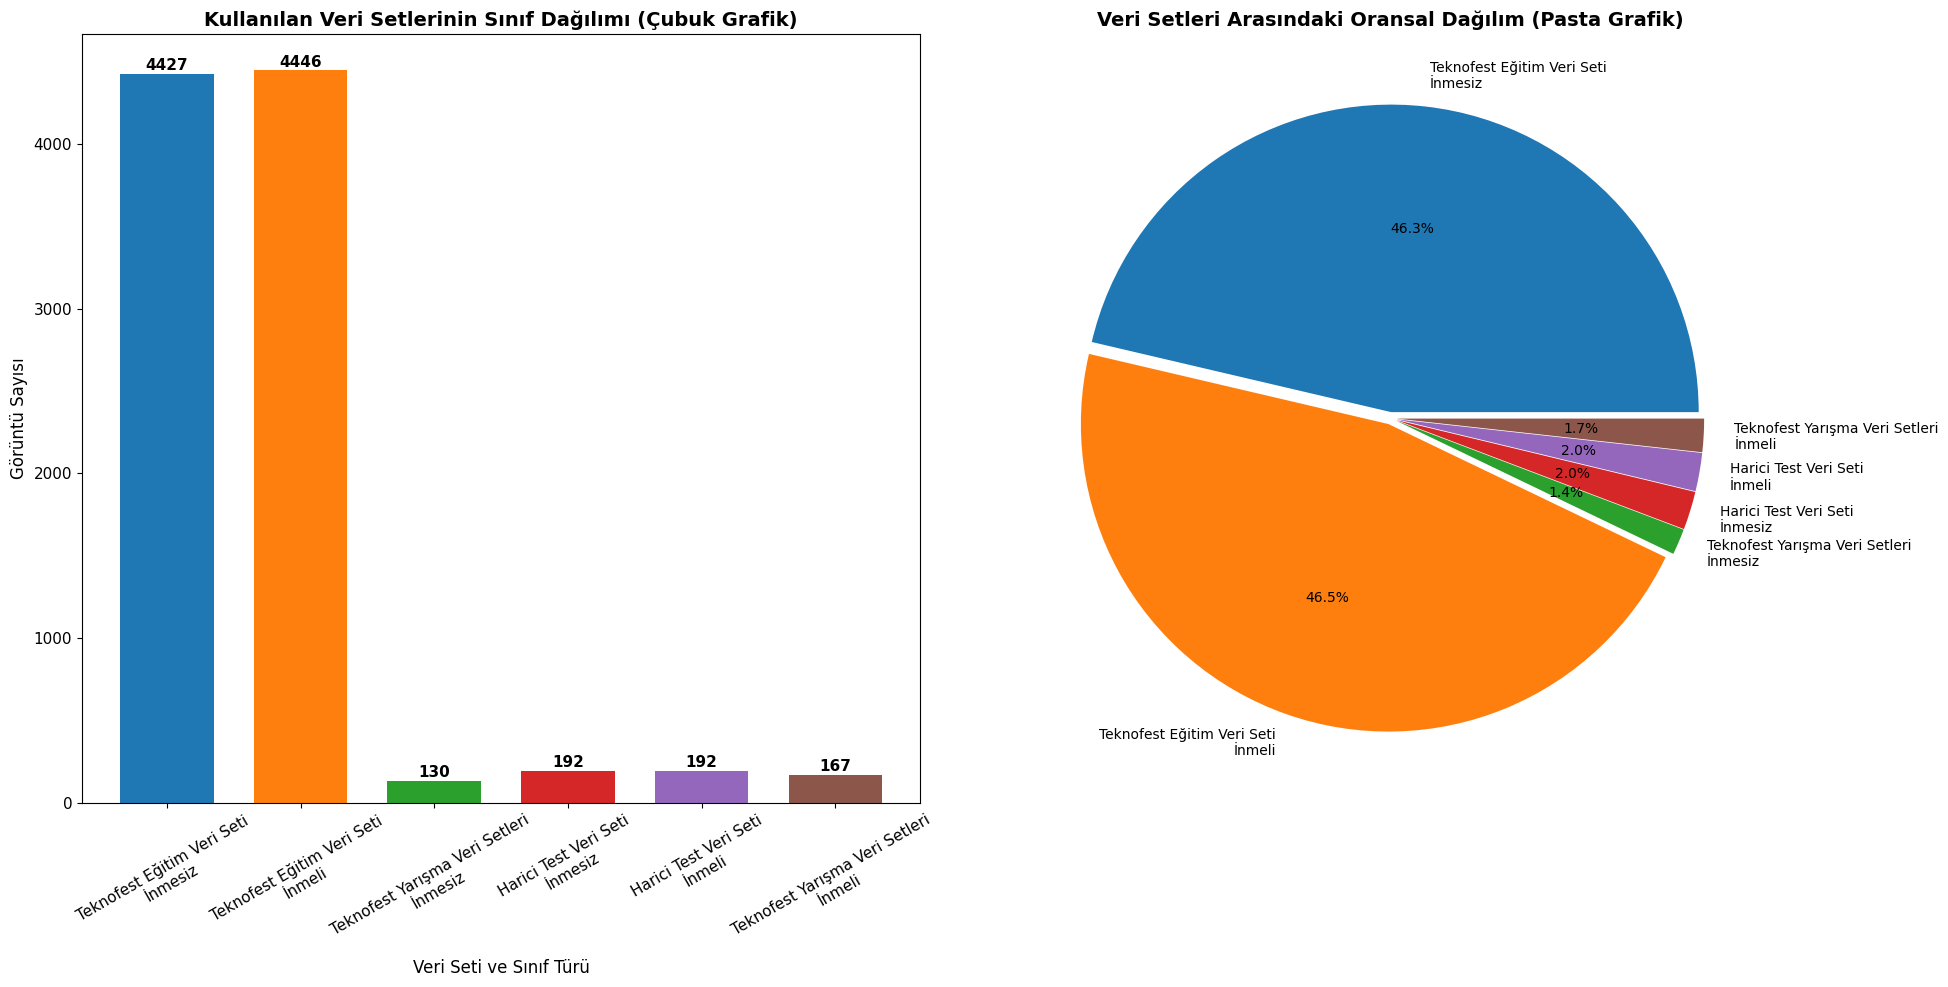

In [13]:
# Font ayarları - tüm grafiklerde tutarlı olması için
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11

# Veri sayılarını hazırla
data_counts = {
    'Teknofest Eğitim Veri Seti\nİnmesiz': NS_images.shape[0],
    'Teknofest Eğitim Veri Seti\nİnmeli': S_images.shape[0],
    'Teknofest Yarışma Veri Setleri\nİnmesiz': NS_test_images.shape[0],
    'Harici Test Veri Seti\nİnmesiz': external_NS_images.shape[0],
    'Harici Test Veri Seti\nİnmeli': external_S_images.shape[0],
    'Teknofest Yarışma Veri Setleri\nİnmeli': S_test_images.shape[0]
}

# Subplot oluştur
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Patlama efekti için değerler - pasta grafiği dilimlerini daha az ayırmak için
explode = [0.02] * len(data_counts)

# Önce pie plot çizerek renkleri alalım
pie = ax2.pie(data_counts.values(), labels=data_counts.keys(), autopct='%1.1f%%',
             explode=explode, textprops={'fontsize': 10}, shadow=False)
ax2.set_title('Veri Setleri Arasındaki Oransal Dağılım (Pasta Grafik)', fontsize=14, fontweight='bold')

# Legend'i kaldırdık

# Pie plot'tan renkleri al
colors = [patch.get_facecolor() for patch in pie[0]]

# Bar plot - pie plot'tan alınan renklerle
bars = ax1.bar(data_counts.keys(), data_counts.values(), color=colors, width=0.7)
ax1.set_title('Kullanılan Veri Setlerinin Sınıf Dağılımı (Çubuk Grafik)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=30) # Daha iyi okunabilirlik için açıyı 30 dereceye değiştirdik
ax1.set_xlabel('Veri Seti ve Sınıf Türü', fontsize=12)
ax1.set_ylabel('Görüntü Sayısı', fontsize=12)

# Değerleri bar'ların üzerine yaz
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5, # Biraz daha yukarıda
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

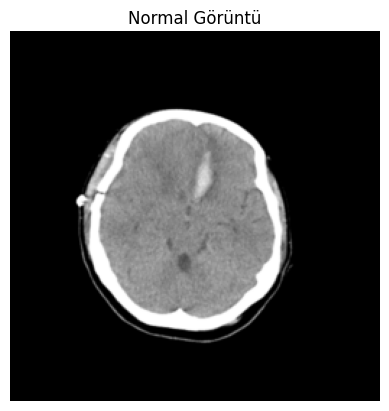

In [10]:
sample_image = S_images[0]

plt.imshow(sample_image.permute(1, 2, 0))
plt.title("Normal Görüntü", fontsize=12)
plt.axis('off')
plt.show()

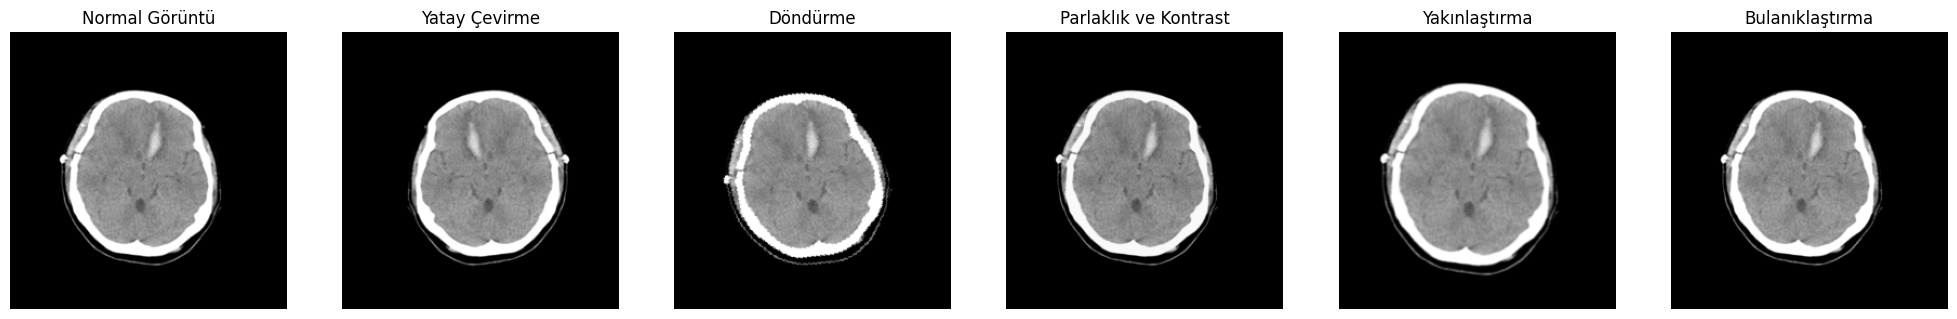

In [11]:
# Horizontal flip

horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)(sample_image)


# Rotation

rotation = transforms.RandomRotation(degrees=15)(sample_image)

# Brightness

brightness = transforms.ColorJitter(brightness=0.2, contrast=0.2)(sample_image)

# Zoom

zoom = transforms.Resize((int(256*1.1), int(256*1.1)))(sample_image)
zoom = transforms.CenterCrop(256)(zoom)

# Blur

blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))(sample_image)

# Show the images

fig, axs = plt.subplots(1, 6, figsize=(25, 5))

axs[0].imshow(sample_image.permute(1, 2, 0))
axs[0].set_title("Normal Görüntü", fontsize=12)
axs[0].axis('off')

axs[1].imshow(horizontal_flip.permute(1, 2, 0))
axs[1].set_title("Yatay Çevirme", fontsize=12)
axs[1].axis('off')

axs[2].imshow(rotation.permute(1, 2, 0))
axs[2].set_title("Döndürme", fontsize=12)
axs[2].axis('off')

axs[3].imshow(brightness.permute(1, 2, 0))
axs[3].set_title("Parlaklık ve Kontrast", fontsize=12)
axs[3].axis('off')

axs[4].imshow(zoom.permute(1, 2, 0))
axs[4].set_title("Yakınlaştırma", fontsize=12)
axs[4].axis('off')

axs[5].imshow(blur.permute(1, 2, 0))
axs[5].set_title("Bulanıklaştırma", fontsize=12)
axs[5].axis('off')

plt.show()